# 第8章: ニューラルネット

## 70.単語ベクトルの和による特徴量

In [1]:
import gensim
import numpy as np
import pandas as pd
import re

# その他
import warnings

In [2]:
#configs
TRAIN_DATA_PATH ='./ch6_folder/save_data/train.csv'
VALID_DATA_PATH = './ch6_folder/save_data/valid.csv'
TEST_DATA_PATH = './ch6_folder/save_data/test.csv'
GOOGLE_MODEL_PATH = './ch7_folder/model/GoogleNews-vectors-negative300.bin'

Warningを消すために以下のコードを追加します。

In [3]:
warnings.simplefilter('ignore')

In [4]:
model = gensim.models.KeyedVectors.load_word2vec_format(GOOGLE_MODEL_PATH, binary=True)

In [5]:
model_vocab_list = list(model.wv.vocab.keys())

記事の見出しの単語列 $(w_{i,1}, \ldots, w_{i,T_i})$ に対して、embeddingをおこない、以下のような特徴ベクトルを生成すると書いてあります。

$$
    {x}_i = \frac{1}{T_i}\sum_{1 \leq t \leq T_i} {emb}(w_{i,t}) 
$$

これは、各単語数に関する平均を特徴量にするということですね。

In [6]:
CATEGORY_TAG = {'b': 0, 't': 1, 'e': 2, 'm': 3}

In [7]:
df_train = pd.read_csv(TRAIN_DATA_PATH)
df_valid = pd.read_csv(VALID_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)

In [8]:
train_titles_list = [title.split() for title in df_train['TITLE'].values.tolist()]
valid_titles_list = [title.split() for title in df_valid['TITLE'].values.tolist()]
test_titles_list = [title.split() for title in df_test['TITLE'].values.tolist()]

In [9]:
train_length = len(train_titles_list)
valid_length = len(valid_titles_list)
test_length = len(test_titles_list)
print(train_length, valid_length, test_length)

10672 1334 1334


In [10]:
def tokenize(word: str) -> str:
    """
    """
    word = word.replace('-', '')
    word = word.replace('.', '')
    word = word.replace('\'', '')
    word = word.replace(':', '')
    return word

In [11]:
def get_embedding_matrix(titles_list):
    feature_vecs_list = []
    
    for title in titles_list:
        tmp_vecs_list =[]
        for word in title:
            word = tokenize(word)
            try:
                vec = model[word]
                tmp_vecs_list.append(vec)
            except KeyError as e:
                pass
        
        if len(tmp_vecs_list) == 1:
            feature_vec = tmp_vecs_list[0]
        else:
            np_vecs = np.array(tmp_vecs_list)
            feature_vec = np.mean(np_vecs, axis=0)
        feature_vecs_list.append(feature_vec)
    return np.array(feature_vecs_list)

In [12]:
X_train = get_embedding_matrix(train_titles_list)
X_valid = get_embedding_matrix(valid_titles_list)
X_test = get_embedding_matrix(test_titles_list)

In [13]:
X_train.shape

(10672, 300)

In [14]:
X_valid.shape

(1334, 300)

In [15]:
X_test.shape

(1334, 300)

In [16]:
y_train= pd.read_csv(TRAIN_DATA_PATH)['CATEGORY'].map(CATEGORY_TAG).values
y_valid = pd.read_csv(VALID_DATA_PATH)['CATEGORY'].map(CATEGORY_TAG).values
y_test = pd.read_csv(TEST_DATA_PATH)['CATEGORY'].map(CATEGORY_TAG).values

In [17]:
Y_train = np.eye(4)[y_train]
Y_valid = np.eye(4)[y_valid]
Y_test = np.eye(4)[y_test]

In [18]:
y_train[1]

0

In [19]:
y_train.shape

(10672,)

In [20]:
Y_train.shape

(10672, 4)

In [21]:
y_valid.shape

(1334,)

In [22]:
Y_valid.shape

(1334, 4)

In [23]:
y_test.shape

(1334,)

In [24]:
Y_test.shape

(1334, 4)

## 71. 単層NNによる予測

個人的にこういう時にKerasを使うのが好きなのでKerasを使っていきます。
重みの初期化のところ、毎回同じ値を取りたいのでrandom seedみたいなことをしたいのですが、どうすればいいですかね。

In [25]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [26]:
def predict_nn():
    inputs = Input(shape=(300,))
    outputs = Dense(4, activation='softmax') (inputs)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [27]:
x_1 = X_train[:1]
X_1_4 = X_train[:4]

In [28]:
model_71 = predict_nn()

In [29]:
model_71.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 1204      
Total params: 1,204
Trainable params: 1,204
Non-trainable params: 0
_________________________________________________________________


In [30]:
y_1 = model_71.predict(x_1)
Y_1_4 = model_71.predict(X_1_4)

In [31]:
y_1

array([[0.239564  , 0.281665  , 0.22245732, 0.25631362]], dtype=float32)

In [32]:
Y_1_4

array([[0.23956403, 0.28166503, 0.22245732, 0.25631365],
       [0.2567518 , 0.28086486, 0.20096698, 0.26141632],
       [0.26838878, 0.27673537, 0.24071665, 0.2141592 ],
       [0.24942772, 0.29014164, 0.2160344 , 0.24439625]], dtype=float32)

## 72. 損失と勾配の計算

文面からは、実際自分でクロスエントロピー損失関数や、勾配を`numpy`や`math`を用いて作成して、作成した関数を用いて求めてほしいのか、71とかで使ったモジュールを用いてやって欲しいのかイマイチわからないのですが、自作はせずにkerasを使ってやります。

In [33]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.backend import gradients

In [34]:
y_train_1 = Y_train[:1]
Y_train_1_4 = Y_train[:4]

In [35]:
CategoricalCrossentropy?

Init signature:
CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0,
    reduction='auto',
    name='categorical_crossentropy',
)
Docstring:     
Computes the crossentropy loss between the labels and predictions.

Use this crossentropy loss function when there are two or more label classes.
We expect labels to be provided in a `one_hot` representation. If you want to
provide labels as integers, please use `SparseCategoricalCrossentropy` loss.
There should be `# classes` floating point values per feature.

In the snippet below, there is `# classes` floating pointing values per
example. The shape of both `y_pred` and `y_true` are
`[batch_size, num_classes]`.

Usage:

```python
cce = tf.keras.losses.CategoricalCrossentropy()
loss = cce(
  [[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]],
  [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])
print('Loss: ', loss.numpy())  # Loss: 0.0945
```

Usage with the `compile` API:

```python
model = tf.keras.Model(inputs, outputs)
model.

In [36]:
cce = CategoricalCrossentropy()

$\hat{y}_1$のクロスエントロピー損失は、

In [37]:
cce(y_train_1,y_1).numpy()

1.4289346

$\hat{Y}$のクロスエントロピー損失は、

In [38]:
cce(Y_train_1_4,Y_1_4).numpy()

1.4295504

損失を求められたので、次は勾配を求めます。実は、`keras`の関数である`keras.backend.gradient`を用いると`RuntimeError`がでます。
そのため、今回は`tf.GradientTape()`を用いて求めます。
ちなみに、先ほど定義したモデルから、weightの行列を取得し、そのweight行列と`numpy`の`gradient`を用いて計算して、gradientを求めようと思ったのですが、`numpy.gradient`の仕様がよくわからなくてやめました。誰か書ける人がいたら教えてください。

In [39]:
def calculate_grad(x,y):
    
    def _loss_fn(y_predict, y):
        return cce(y_predict, y)

    inputs = tf.convert_to_tensor(x)
    targets = tf.convert_to_tensor(y)
    with tf.GradientTape() as tape:
        y_predict = model_71(inputs)
        loss = _loss_fn(y_predict, targets)
    grads = tape.gradient(loss, model_71.variables)
    
    return grads

In [40]:
calculate_grad(x_1, y_train_1)

[<tf.Tensor: shape=(300, 4), dtype=float32, numpy=
 array([[ 0.0500014 , -0.01852049, -0.01462737, -0.01685355],
        [-0.01679515,  0.00622091,  0.00491324,  0.005661  ],
        [ 0.01351804, -0.00500708, -0.00395456, -0.00455641],
        ...,
        [-0.19757338,  0.07318108,  0.05779798,  0.06659439],
        [-0.15279485,  0.05659514,  0.0446985 ,  0.05150127],
        [ 0.2987795 , -0.11066777, -0.08740474, -0.10070708]],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-2.9362829 ,  1.0875977 ,  0.85897815,  0.98970807], dtype=float32)>]

In [41]:
calculate_grad(x_1, y_train_1)[0].shape

TensorShape([300, 4])

In [42]:
calculate_grad(X_1_4, Y_train_1_4)

[<tf.Tensor: shape=(300, 4), dtype=float32, numpy=
 array([[-0.112044  ,  0.05510155,  0.04094441,  0.01599805],
        [-0.11293994,  0.05594374,  0.04183282,  0.01516342],
        [ 0.02072998, -0.00277632, -0.00112422, -0.01682947],
        ...,
        [-0.07940362,  0.01085887,  0.00749503,  0.06104969],
        [-0.16243216,  0.0715156 ,  0.05421773,  0.03669881],
        [ 0.09662345, -0.01037101, -0.00720807, -0.0790443 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-2.025799  ,  1.0929042 ,  0.8475219 ,  0.08537273], dtype=float32)>]

In [43]:
calculate_grad(X_1_4, Y_train_1_4)[0].shape

TensorShape([300, 4])

## 73. 確率的勾配降下法による学習

>確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ.

とのことなので、さっきのモデルを用いて、行いたいと思います。

In [44]:
from tensorflow.keras.optimizers import SGD

In [45]:
model_73 = predict_nn()

In [46]:
%%time
opt = SGD(learning_rate=0.01)
model_73.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_73.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid))

Train on 10672 samples, validate on 1334 samples
Epoch 1/100
10672/10672 [==============================] - 0s 46us/sample - loss: 1.1910 - accuracy: 0.6330 - val_loss: 1.0789 - val_accuracy: 0.7534
Epoch 2/100
10672/10672 [==============================] - 0s 26us/sample - loss: 1.0184 - accuracy: 0.7687 - val_loss: 0.9790 - val_accuracy: 0.7631
Epoch 3/100
10672/10672 [==============================] - 0s 25us/sample - loss: 0.9390 - accuracy: 0.7792 - val_loss: 0.9151 - val_accuracy: 0.7706
Epoch 4/100
10672/10672 [==============================] - 0s 26us/sample - loss: 0.8838 - accuracy: 0.7797 - val_loss: 0.8668 - val_accuracy: 0.7691
Epoch 5/100
10672/10672 [==============================] - 0s 26us/sample - loss: 0.8411 - accuracy: 0.7795 - val_loss: 0.8282 - val_accuracy: 0.7691
Epoch 6/100
10672/10672 [==============================] - 0s 26us/sample - loss: 0.8065 - accuracy: 0.7803 - val_loss: 0.7964 - val_accuracy: 0.7661
Epoch 7/100
10672/10672 [==========================

## 74.正解率の計測

In [47]:
score = model_73.evaluate(X_test, Y_test, verbose=0)

In [48]:
print('Test loss:{0}'.format(score[0]))
print('Test accuracy:{0}'.format(score[1]))

Test loss:0.41655058169114717
Test accuracy:0.8605697154998779


## 75. 損失と正解率のプロット

Kerasでは、`Callback`というクラスがあり、それを使うことによって、訓練中に関数を適用させることができます。

In [49]:
import os
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

In [50]:
class RealTimePlot(Callback):
    def __init__(self, name=False, absolute=False, log_scale=False, path=os.getcwd() ,save=False):
        super().__init__()
        self.name = name
        self.absolute = absolute
        self.log_scale = log_scale
        self.path = path
        self.save = save

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))
        clear_output(wait=True)
        
        # fig全体の設定
        if self.name:
            fig.suptitle('{0}の学習'.format(self.name))
            
        
        # fig内のax1(サブグラフ)の設定
        if self.log_scale:
            ax1.set_yscale('log')
            
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        # fig内のax2(サブグラフ)の設定
        if self.absolute:
            ax2.set_ylim(0.6, 0.98)

        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="val_accuracy")
        ax2.legend()
        plt.show();
        
    def on_train_end(self, logs={}):
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))
        clear_output(wait=True)
        
        # fig全体の設定
        if self.name:
            fig.suptitle('{0}の学習'.format(self.name))
            
        
        # fig内のax1(サブグラフ)の設定
        if self.log_scale:
            ax1.set_yscale('log')
    
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        # fig内のax2(サブグラフ)の設定
        if self.absolute:
            ax2.set_ylim(0.6, 0.98)

        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="val_accuracy")
        ax2.legend()
        
        if self.save:
            output_fig_name = os.path.join(self.path, self.name + '.png')
            plt.savefig(output_fig_name)
        plt.show();

In [51]:
real_time_plot = RealTimePlot(name='75番')

In [52]:
model_75 = predict_nn()

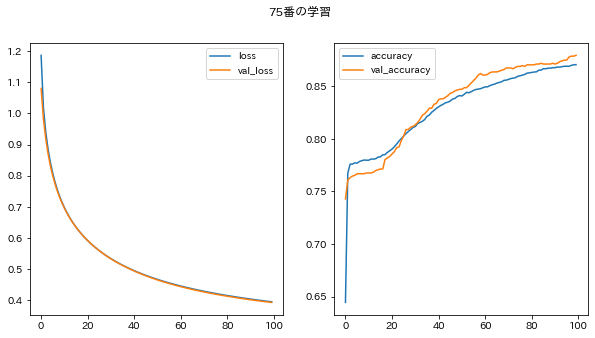

CPU times: user 1min 10s, sys: 7.9 s, total: 1min 18s
Wall time: 1min 3s


In [53]:
%%time
opt = SGD(learning_rate=0.01)
model_75.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_75.fit(X_train, Y_train, epochs=100,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[real_time_plot])

lossもvalidation lossも同じように下がっているのが分かります。しかし奇妙な動きをしてますね。。。

## 76.チェックポイント

こちらも75と同様に、`Callbacks`を用います。

In [54]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

In [55]:
# configs
MODEL_DIR = './ch8_folder/models'

In [56]:
if not os.path.exists(MODEL_DIR):  # ディレクトリが存在しない場合、作成する。
    os.makedirs(MODEL_DIR)
checkpoint = ModelCheckpoint(filepath=os.path.join(MODEL_DIR, "model-{epoch:02d}.h5"), verbose=0,save_weights_only=True, save_freq=1)

In [57]:
model_76 = predict_nn()

先ほどまでエポックは100で行っていましたが、パラメータをたくさん出力したくないため、エポックを10で行います。

In [58]:
opt = SGD(learning_rate=0.01)
model_76.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_76.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[checkpoint])

Train on 10672 samples, validate on 1334 samples
Epoch 1/10
10672/10672 [==============================] - 2s 181us/sample - loss: 1.2007 - accuracy: 0.6371 - val_loss: 1.0789 - val_accuracy: 0.7444
Epoch 2/10
10672/10672 [==============================] - 2s 150us/sample - loss: 1.0174 - accuracy: 0.7623 - val_loss: 0.9774 - val_accuracy: 0.7609
Epoch 3/10
10672/10672 [==============================] - 2s 149us/sample - loss: 0.9374 - accuracy: 0.7718 - val_loss: 0.9133 - val_accuracy: 0.7624
Epoch 4/10
10672/10672 [==============================] - 2s 151us/sample - loss: 0.8824 - accuracy: 0.7756 - val_loss: 0.8652 - val_accuracy: 0.7624
Epoch 5/10
10672/10672 [==============================] - 2s 149us/sample - loss: 0.8398 - accuracy: 0.7765 - val_loss: 0.8267 - val_accuracy: 0.7654
Epoch 6/10
10672/10672 [==============================] - 2s 148us/sample - loss: 0.8053 - accuracy: 0.7772 - val_loss: 0.7950 - val_accuracy: 0.7661
Epoch 7/10
10672/10672 [===========================

これで`MODEL_DIR`内にモデルが生成されていると思います。

## 77.ミニバッチ化

kerasをもちいたミニバッチ化は簡単です。`model.fit`のオプション変数である、`batch_size`で変更が可能です。
問題ではBの値を1,2,4,8,...と書いてあるのですが、1,8,16あたりでやってみます。

In [59]:
model_77_1 = predict_nn()

In [60]:
real_time_plot = RealTimePlot()

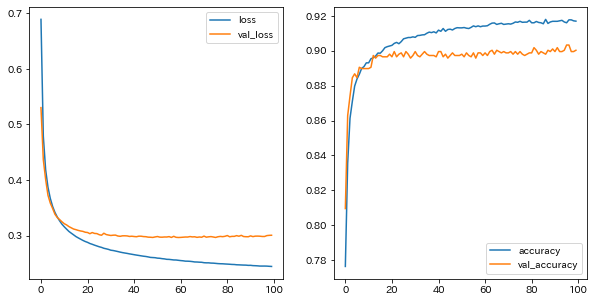

CPU times: user 18min 58s, sys: 2min 47s, total: 21min 45s
Wall time: 14min 59s


In [61]:
%%time
opt = SGD(learning_rate=0.01)
model_77_1.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_77_1.fit(X_train, Y_train, epochs=100, batch_size=1,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[real_time_plot])

In [62]:
score1 = model_77_1.evaluate(X_test, Y_test, verbose=0)

In [63]:
print('Test loss:{0}'.format(score1[0]))
print('Test accuracy:{0}'.format(score1[1]))

Test loss:0.26672721110183795
Test accuracy:0.9077960848808289


In [64]:
model_77_8 = predict_nn()

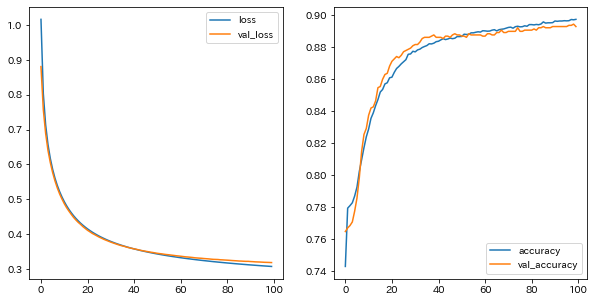

CPU times: user 3min, sys: 24.8 s, total: 3min 24s
Wall time: 2min 26s


In [65]:
%%time
opt = SGD(learning_rate=0.01)
model_77_8.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_77_8.fit(X_train, Y_train, epochs=100, batch_size=8,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[real_time_plot])

In [66]:
score2 = model_77_8.evaluate(X_test, Y_test, verbose=0)

In [67]:
print('Test loss:{0}'.format(score2[0]))
print('Test accuracy:{0}'.format(score2[1]))

Test loss:0.32390749342795433
Test accuracy:0.8890554904937744


In [68]:
model_77_16 = predict_nn()

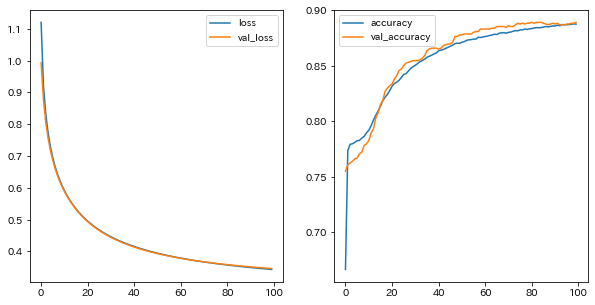

CPU times: user 1min 45s, sys: 13.7 s, total: 1min 59s
Wall time: 1min 28s


In [69]:
%%time
opt = SGD(learning_rate=0.01)
model_77_16.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_77_16.fit(X_train, Y_train, epochs=100, batch_size=16,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[real_time_plot])

In [70]:
score3 = model_77_16.evaluate(X_test, Y_test, verbose=0)

In [71]:
print('Test loss:{0}'.format(score3[0]))
print('Test accuracy:{0}'.format(score3[1]))

Test loss:0.36266527352840644
Test accuracy:0.8785607218742371


## 78.GPU上での学習

こちらは手元の環境ではできないので行いません。

## 79.多層ニューラルネットワーク

先ほどまでは一層のニューラルネットワークをさわってたわけですが、今度は多層のニューラルネットとかを作ってみましょう。
今までの結果から、

- epochが100のままだと過適合しそう
- バッチサイズは小さいとよくなさそうなので、16ぐらいで

みたいが見えるので、そこら辺を意識しながらパラメータを編集します。

In [72]:
from tensorflow.keras.layers import Dropout

In [73]:
def many_nn():
    inputs = Input(shape=(300,))
    x = Dense(200, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax') (x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [74]:
model_79 = many_nn()

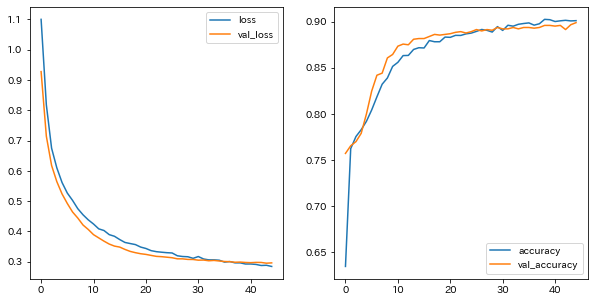

CPU times: user 59.2 s, sys: 7.21 s, total: 1min 6s
Wall time: 46.8 s


In [75]:
%%time
opt = SGD(learning_rate=0.01)
model_79.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_79.fit(X_train, Y_train, epochs=45, batch_size=16,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[real_time_plot])

In [76]:
score4 = model_79.evaluate(X_test, Y_test, verbose=0)
print('Test loss:{0}'.format(score4[0]))
print('Test accuracy:{0}'.format(score4[1]))

Test loss:0.2823952407851212
Test accuracy:0.9002998471260071


Accuracyそこまで上がらなかったですね。。。
本来もう少しパラメータをいじったり特徴量をかえたりしますが、今回は以上にします。